# Price forecasting using deep learning methods

In this project we will test different deep learning architectures for their ability to make accurate predictions about future prices based on historical price data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

In [2]:
# Set the desired inputs
category = 'pasta'
store_id = '1501'
barcode = '7296073053767'

In [3]:
# Import the data
data = readRDS('D:/retail data/rds data/data by store/'+category+'/'+store_id+'.rds')
data = pandas2ri.rpy2py_dataframe(data)

data['Date'] = pd.to_datetime(data['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
data['Date'] = pd.to_datetime(data['Date'], errors='coerce').sort_values()
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.weekday

data = data[data['Barcode']==barcode]
data

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price,Discount,FinalPrice,DiscountDescription,DiscountID,PriceSetDate,Date,Year,Month,Weekday
1,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8,NA_character_,12.8,NA_character_,NA_character_,2015-11-30 12:07:19,2016-01-01,2016,1,4
49,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8,NA_character_,12.8,NA_character_,NA_character_,2015-11-30 12:07:19,2016-01-02,2016,1,5
96,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8,NA_character_,12.8,NA_character_,NA_character_,2015-11-30 12:07:19,2016-01-03,2016,1,6
143,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8,NA_character_,12.8,NA_character_,NA_character_,2015-11-30 12:07:19,2016-01-05,2016,1,1
191,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8,NA_character_,12.8,NA_character_,NA_character_,2015-11-30 12:07:19,2016-01-06,2016,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111199,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5,NA_character_,13.5,NA_character_,NA_character_,2021-02-19 05:06:20,2021-02-24,2021,2,2
111268,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5,NA_character_,13.5,NA_character_,NA_character_,2021-02-19 05:06:20,2021-02-25,2021,2,3
111339,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5,NA_character_,13.5,NA_character_,NA_character_,2021-02-19 05:06:20,2021-02-26,2021,2,4
111412,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5,NA_character_,13.5,NA_character_,NA_character_,2021-02-19 05:06:20,2021-02-27,2021,2,5


### Data pre-processing

Since we know that our dataset documents price changes during the day, we will aggragate the prices to the date level.

In [4]:
# Group the data by date and calculate the mean of each group
data_agg = data.groupby('Date', as_index = False).agg({'FinalPrice':'mean', 'Barcode':'first', 'ProductDescription':'first', 'Manufacturer':'first', 'Category':'first', 'ChainID':'first', 'ChainName':'first', 'SubChainID':'first', 'SubChainName':'first','StoreID':'first', 'StoreName':'first', 'Price':'mean'})
data_agg

,Date,FinalPrice,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price
0,2016-01-01,12.8,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8
1,2016-01-02,12.8,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8
2,2016-01-03,12.8,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8
3,2016-01-04,12.8,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8
4,2016-01-05,12.8,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,2021-02-24,13.5,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5
1342,2021-02-25,13.5,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5
1343,2021-02-26,13.5,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5
1344,2021-02-27,13.5,7296073053767,דפיי לזניה שופרסל 500 גרם,שופרסל,פסטה ספגטי ולזניה,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,13.5


#### Handling missing data with imputation

To provide a more accurate picture of the business environment, we will use imputation. Imputing missing data can also improve the accuracy of time series forecasts and the quality of business decisions based on the analysis of the data.

In [5]:
##### Check for missing dates in the data

# Create a dataframe with the date range
date_range = pd.date_range('2016-01-01 00:00:00', '2021-02-28 00:00:00')
date_df = pd.DataFrame({'Date': date_range})

# Merge the dataframe with the date range
merged_data = date_df.merge(data_agg, on='Date', how='left')

# Check for missing dates
missing_dates = merged_data[merged_data['FinalPrice'].isnull()]['Date']
len(missing_dates)

540

##### Last observation carried forward (LOCF)

In [6]:
# Impute missing values with the last non-null value
merged_data['FinalPrice'] = merged_data['FinalPrice'].fillna(method='ffill')

# Check if there is any missing value
print(merged_data['FinalPrice'].isnull().sum())

0


##### Data preparation for NN

Even though the prices are in the same currency and the range of values for the prices is relatively small, neural network models can be sensitive to the scale of the input data, and scaling the data can improve the performance of the model.

In [7]:
# Scale the data
scaler = MinMaxScaler()
merged_data['FinalPrice'] = scaler.fit_transform(merged_data[['FinalPrice']])

In [8]:
# Split into train and test sets
train_size = int(len(merged_data['FinalPrice']) * 0.67)
test_size = len(merged_data['FinalPrice']) - train_size
train, test = merged_data['FinalPrice'][0:train_size], merged_data['FinalPrice'][train_size:len(merged_data['FinalPrice'])]
print(len(train), len(test))

1263 623


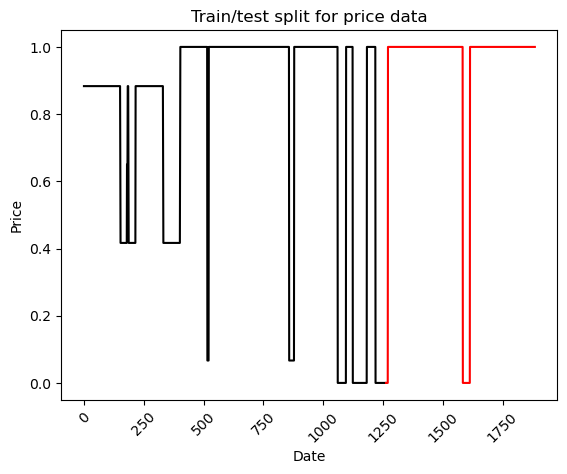

In [9]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/test split for price data")
plt.show()

We will prepare time series data for use in a neural network models. We will reshape the input data into a format that can be used by the forecasting model

In [10]:
def prepare_time_series_data(train, test, look_back):
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back):
        dataX, dataY = [], []
        if look_back==1:
            look_back_range=1
        else:
            look_back_range=0
        for i in range(len(dataset)-look_back-look_back_range):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return np.array(dataX), np.array(dataY)
    
   
    trainX, trainY = create_dataset(train.reset_index(drop=True), look_back)
    testX, testY = create_dataset(test.reset_index(drop=True), look_back)
    
    if look_back==1:
        # Reshape into [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    else:
        # Reshape input to be [number of samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 
        
    # Convert to TensorFlow tensors
    trainX = tf.convert_to_tensor(trainX, dtype=tf.float32)
    trainY = tf.convert_to_tensor(trainY, dtype=tf.float32)
    testX = tf.convert_to_tensor(testX, dtype=tf.float32)
    testY = tf.convert_to_tensor(testY, dtype=tf.float32)
    
    return trainX, trainY, testX, testY

In [11]:
# track models performance
log_models = pd.DataFrame(columns=["Model","Train_MSE","Test_MSE"])

### Time series models

#### Vanilla RNN

Since our data is not stationary we will use vanilla RNN to learn and maintain a hidden state that captures information about the past, which can be used to make predictions about the future. Even though dropout try to avoid overfitting, we will not use it since it significantly decrease the model performance here.

In [12]:
# create and fit the Vanilla RNN network
look_back = 1
trainX, trainY, testX, testY = prepare_time_series_data(train, test, look_back)

# Define the model architecture
model = Sequential()
model.add(SimpleRNN(8, input_shape=(1, look_back), return_sequences=True))
model.add(SimpleRNN(4))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Vanilla RNN', trainScore ,testScore]

20/20 [==============================] - 0s 2ms/step
Train Score: 0.52 RMSE
Test Score: 0.42 RMSE


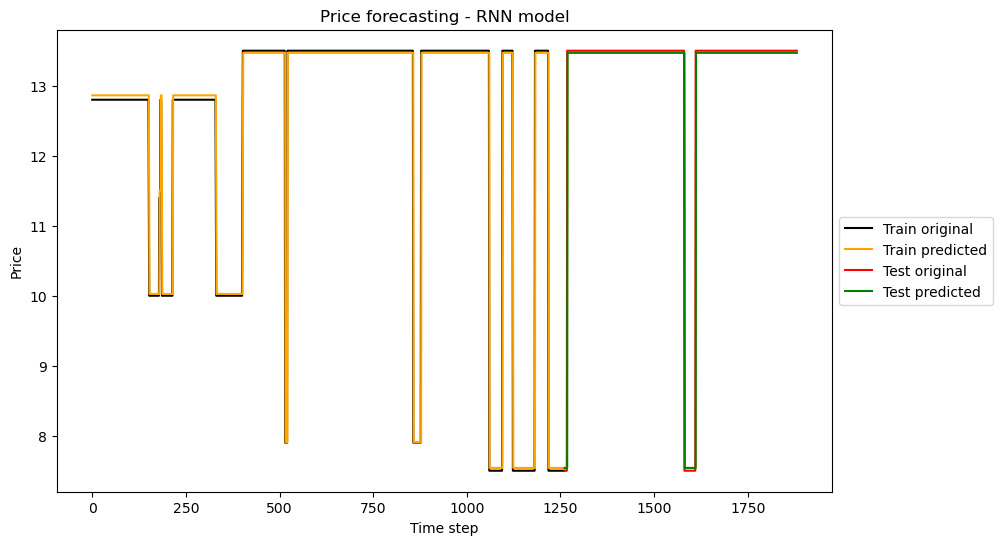

In [13]:
# Get the length of the train data
train_length = len(orig_trainY[0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[0])), orig_trainY[0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price forecasting - RNN model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Long short-term memory (LSTM)

With LSTM we will try to overcome the problems of Vanilla RNNs in handling long-term dependencies since it can remember information for longer periods of time and selectively choose which information to discard and which to keep. Here we will also apply recurrent dropout to the recurrent connections in the recurrent layers.

In [14]:
# create and fit the LSTM network
look_back = 1
trainX, trainY, testX, testY = prepare_time_series_data(train, test, look_back)

# Define the model architecture
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back), return_sequences=True))
model.add(SimpleRNN(4))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['LSTM', trainScore ,testScore]

20/20 [==============================] - 0s 3ms/step
Train Score: 0.51 RMSE
Test Score: 0.42 RMSE


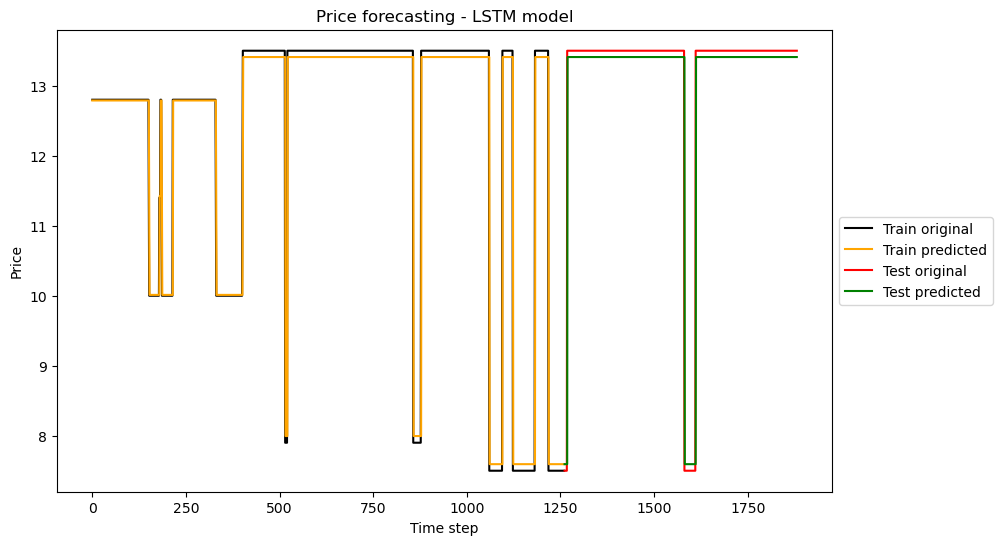

In [15]:
# Get the length of the train data
train_length = len(orig_trainY[0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[0])), orig_trainY[0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price forecasting - LSTM model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Gated recurrent units (GRU)

GRU is designed to overcome the problems of Vanilla RNNs and LSTMs in handling long-term dependencies in time series data. GRU has similar functionality as LSTMs, but with a simpler structure and fewer parameters.

In [16]:
# create and fit the GRU network
look_back = 1
trainX, trainY, testX, testY = prepare_time_series_data(train, test, look_back)

# Define the model architecture
model = Sequential()
model.add(GRU(8, input_shape=(1, look_back), return_sequences=True))
model.add(GRU(4))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['GRU', trainScore ,testScore]

20/20 [==============================] - 0s 4ms/step
Train Score: 0.52 RMSE
Test Score: 0.41 RMSE


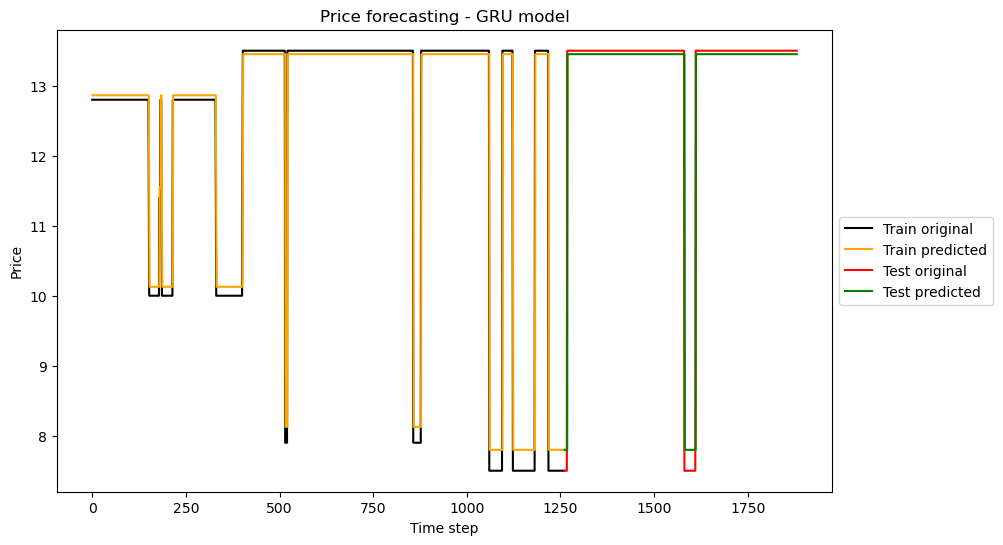

In [17]:
# Get the length of the train data
train_length = len(orig_trainY[0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[0])), orig_trainY[0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price forecasting - GRU model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Encoder decoder model

Encoder-decoder model can handle longer time series since it can encode the input sequence into a fixed-length vector, which allows the model to work with longer sequences of data.

In [18]:
# create and fit the encoder-decoder network
look_back = 1
trainX, trainY, testX, testY = prepare_time_series_data(train, test, look_back)

# Define the model architecture
encoder = Sequential()
encoder.add(LSTM(8, input_shape=(1, look_back), return_sequences=True))
encoder.add(SimpleRNN(4))

decoder = Sequential()
decoder.add(RepeatVector(look_back))
decoder.add(LSTM(8, return_sequences=True))
decoder.add(Dense(1))

model = Sequential()
model.add(encoder)
model.add(decoder)
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
orig_testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Encoder decoder model', trainScore ,testScore]

20/20 [==============================] - 0s 5ms/step
Train Score: 0.51 RMSE
Test Score: 0.41 RMSE


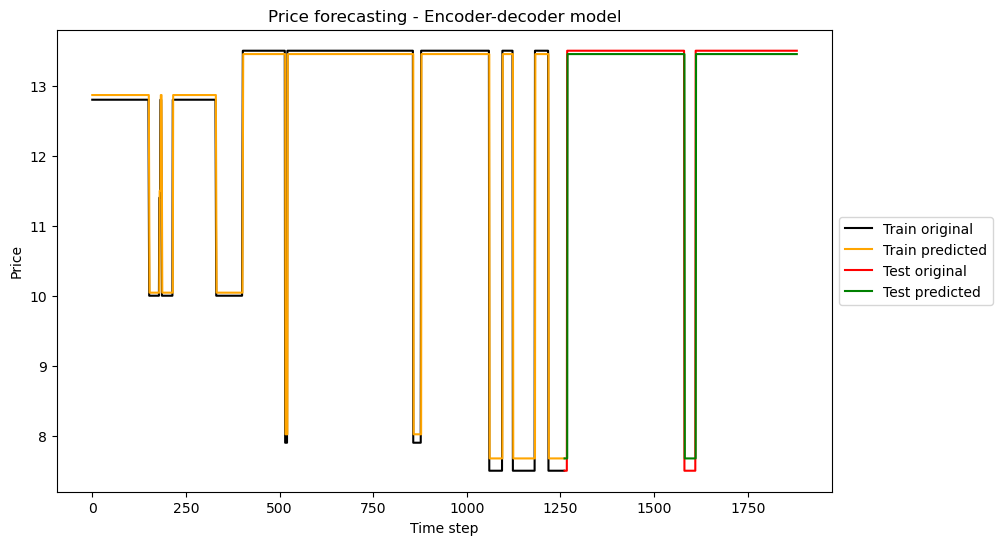

In [19]:
# Get the length of the train data
train_length = len(orig_trainY[0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[0])), orig_trainY[0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price forecasting - Encoder-decoder model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Vanilla CNN

The vanilla CNN model for time series data involves using 1D convolutional layers followed by pooling layers to capture local patterns in the time series sequence. Unlike RNNs, CNNs process data with a fixed-size receptive field, which makes them effective at capturing local dependencies and patterns within the time series.

In [20]:
# Create and fit the CNN network
look_back = 3
trainX, trainY, testX, testY = prepare_time_series_data(train, test, look_back)

# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Vanilla CNN', trainScore ,testScore]


20/20 [==============================] - 0s 1ms/step
Train Score: 0.52 RMSE
Test Score: 0.41 RMSE


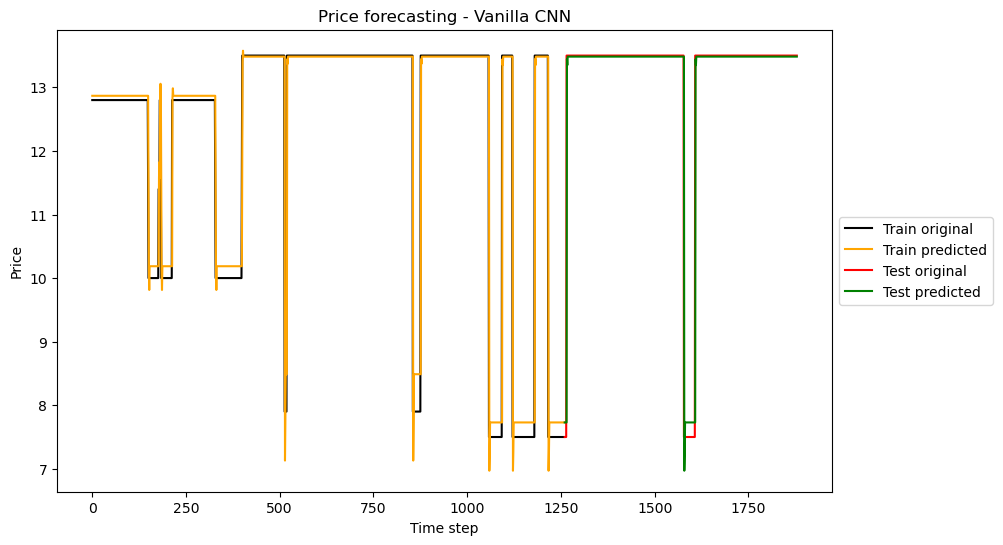

In [21]:
# Get the length of the train data
train_length = len(orig_trainY[0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[0])), orig_trainY[0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price forecasting - CNN model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Model comparison

In [22]:
# Present scores of all the models
log_models.sort_values(by="Test_MSE",ascending=True)

,Model,Train_MSE,Test_MSE
4,Vanilla CNN,0.515650,0.410815
2,GRU,0.517556,0.411280
3,Encoder decoder model,0.514105,0.412605
0,Vanilla RNN,0.515228,0.415615
1,LSTM,0.513417,0.420401


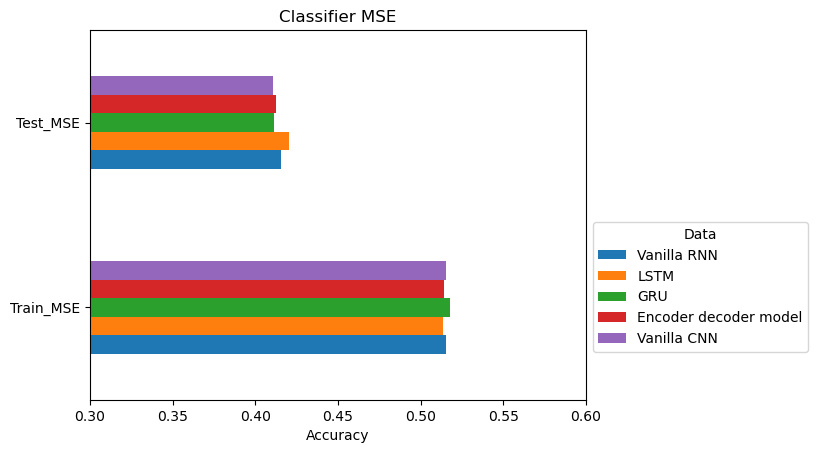

In [23]:
log_models.set_index('Model').T.plot.barh()
plt.title('Classifier MSE')
plt.legend(title='Data', bbox_to_anchor=(1, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.3,0.6))
plt.show()

By the comparison we see that the CNN model performed better than other models.